In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [3]:
#tf.keras.backend.set_floatx('float64')

In [4]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[1],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [5]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2018-11-14'
test_start = '2018-11-15'
test_end = '2020-05-15'

remove_columns = ['date', '종가', '시가', '고가', '저가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble5'
channel = False

trans_day = 5

target_alpha = 100
future_day = 5
train_end_idx = -2
n_timestep = 120
time_interval = 1
input_size = 809
n_unit = 800
batch_size = 32
learning_rate = 0.0005
epochs = 399

alpha = 0.5

comment = "2개의 모델 (지수 등락 예측, 기하평균 수익률 예측), 2개의 loss function으로 번갈아 학습, 모델1의 결과를 모델2에서 기하평균 수익이 최대 수익이 되도록 보정"

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [6]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha 

In [7]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,"주요상품선물_천연가스(선물, NYMEX)($/mmBtu)",주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,1.653438,-0.853010,0.974513,0.827681,0.373581,0.614542,1.379599,116.85,120.10,116.65
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,1.687061,-0.039689,0.193571,1.002058,0.594935,0.706918,6.762029,120.85,121.70,115.35
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,1.809524,0.800355,0.031266,0.069626,0.430159,0.725768,3.714648,116.55,119.70,115.95
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.213642,1.515992,0.623370,0.378121,0.084769,0.352875,1.341719,119.35,120.25,116.80
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,0.689954,3.856851,0.568635,-0.322023,0.518339,0.702038,-5.190029,120.40,123.45,119.75
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,0.332052,2.657684,1.222974,-0.720402,0.474125,0.440887,-8.577320,122.90,123.60,120.95
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,0.557674,3.026664,2.114708,-0.407511,0.622228,0.721716,-7.145757,122.40,124.10,121.85
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,0.812787,3.316674,1.871659,-0.157431,0.985272,1.379493,-8.302808,120.85,125.05,120.40
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,0.675096,2.384344,0.988933,-0.154629,0.473525,0.907189,-7.447249,123.60,124.75,119.85
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,0.504701,1.935983,0.085505,-0.246361,0.529501,0.923675,-8.017241,118.85,119.00,115.25


In [8]:
"""
def loss_fn_(m, train_x, train_y):
    
    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))
    targets = train_y[:, n_timestep-1, 1:].reshape((-1))
    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))
    rates = (tagets - bse_prices) / base_prices
    updown = np.sign(targets - base_prices)
    preds = model(train_x)
    
    
    returns = [1.0]
    avg_return = 1.0
    avg_std = 0.0
    state = np.zeros((4))
    state[0] = 1.0 # average return
    state[1] = 0.0 # standard dev. of returns
    state[2] = 1.0
    state[3] = preds[train_x[0]]
    
    model2 = layers.Dense(units=10, activaton='tanh')
    
    #investment rate
    inv_r = np.zeros((len(train_y)))
    best_inv = np.zeros((len(train_y)))
    
    for i in range(len(targets)):
        state[0] = 
        state[1] = 
        state[2] = (len(train_y) - i) / len(train_y) 
        inv_r[i] = model2(state)
        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))
        
        r = tf.random.normal([100], mean=inv_r[i])
        sharp_ratio = np.zeros((len(r)))
        returns_random = [1.0]

        for j in range(len(r)):  
            returns_random.append(rates[i]*r[j] + 1-abs(r[j]))
            for k in range(i+1, len(train_y)):
                state[0] =
                state[1] = 
                state[2] = (len(train_y) - k) / len(train_y)
                inv_r[k] = model2(state, training=False)
                returns_random.append(rates[k]*inv_r[k] + 1-abs(inv_r[k]))
            avg_return = tf.math.reduce_prod(returns_random)**(1/(len(r)-i))
            std_return = tf.math.reduce_std(returns_random)
            sharp_ratio[j] = avg_return / std_return
        best_return_index = tf.math.argmax(sharp_ratio)
        best_inv[i] = r[best_return_index]

    return tf.math.square(inv_r - best_inv)
"""

"\ndef loss_fn_(m, train_x, train_y):\n    \n    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))\n    targets = train_y[:, n_timestep-1, 1:].reshape((-1))\n    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))\n    rates = (tagets - bse_prices) / base_prices\n    updown = np.sign(targets - base_prices)\n    preds = model(train_x)\n    \n    \n    returns = [1.0]\n    avg_return = 1.0\n    avg_std = 0.0\n    state = np.zeros((4))\n    state[0] = 1.0 # average return\n    state[1] = 0.0 # standard dev. of returns\n    state[2] = 1.0\n    state[3] = preds[train_x[0]]\n    \n    model2 = layers.Dense(units=10, activaton='tanh')\n    \n    #investment rate\n    inv_r = np.zeros((len(train_y)))\n    best_inv = np.zeros((len(train_y)))\n    \n    for i in range(len(targets)):\n        state[0] = \n        state[1] = \n        state[2] = (len(train_y) - i) / len(train_y) \n        inv_r[i] = model2(state)\n        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))\n        \n 

In [9]:
def make_remaining_days(n_batches, n_steps):
    remaining_days = []
    for i in range(n_batches):
        temp = []    
        for j in range(n_steps):
            temp.append((n_batches - i) / n_batches)
        remaining_days.append(np.array(temp))
    return np.array(remaining_days)

In [10]:
#@tf.function
def loss_fn_model1(m1, train_x, train_y):
    
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    preds = tf.cast(m1(train_x), dtype=tf.float64)
    profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds, dtype=tf.float64)
    
    loss1 = keras.losses.MSE(preds, updown)
    
    batches = train_y.shape[0]

    return_plus = []
    return_minus = []
    for i in range(batches):
        if profits[i, -1, 0] - 1 > 0: return_plus.append(profits[i, -1, 0]-1)      
        else: return_minus.append(1-profits[i, -1, 0])    

    loss2 = tf.cast(tf.math.reduce_mean(return_plus), dtype=tf.float64) - tf.cast(tf.math.reduce_mean(return_minus), dtype=tf.float64) 
    
    return loss1 - loss2


In [11]:
#@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    preds = tf.cast(m1(train_x), dtype=tf.float64)
    profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds, dtype=tf.float64)
    
    batches = train_y.shape[0]
    steps = train_y.shape[1]     

    n = - int(future_day/time_interval) # calc the number of unkown steps    
    
    # input = [preds, profits, the rate of remaining days]
    train_x_m2 = np.zeros((batches, steps, 3))
    train_x_m2[:, :, 0] = preds[:, :, 0]
    train_x_m2[:, :, 1] = profits[:, :, 0]
    train_x_m2[:, :, 2] = make_remaining_days(batches, steps)
    
    # unknown future profits are relaced by average profits
    #for i in range(len(train_x_m2)):
    #    train_x_m2[i, n:, 1] = tf.math.reduce_mean(train_x_m2[i, :n, 1])

    train_x_m2 = tf.concat([preds, profits], 2)
    train_x_m2 = tf.concat([train_x_m2, make_remaining_days(batches, steps).reshape((batches, steps, 1))], 2)    

    # model2의 output이 목표일까지의 남은 일수의 기하평균 수익률이 되도록 학습
    avg_returns = []
    
    for i in range(batches):
      
        returns = []
        for j in range(i+1, batches):
            returns.append(profits[j, -1, 0])
        avg_returns.append(tf.cast(tf.math.reduce_prod(returns)**(1/(batches-i)), dtype=tf.float64))
    
    loss = keras.losses.MSE(tf.reshape(m2(train_x_m2)[:, -1, 0], [-1]), avg_returns)

  
    return loss


In [12]:
#@tf.function
def test(m1, m2, test_x, test_y):    
    rates = test_y / 100
    n = - int(future_day/time_interval)
    for i in range(len(rates)):
        rates[i, n:, 0] = 0#tf.math.reduce_mean(rates[i, :n, 0])
    preds = tf.cast(m1.predict(test_x), dtype=tf.float64)
    #rates = tf.cast(tf.random.normal((), mean=test_y, stddev=1) / 100, dtype=tf.float64)
    profits = 1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds
    
    batches = test_y.shape[0]
    steps = test_y.shape[1]     

    test_x_m2 = np.concatenate((preds, profits), axis=2)
    test_x_m2 = np.concatenate((test_x_m2, make_remaining_days(batches, steps).reshape(batches, steps, 1)), axis=2)
    
    correct_preds = np.array(preds[:, -1, 0]).reshape(-1).copy()
    
    for i in range(batches):

        for j in range(100):
            
            random_test_x_m2 = test_x_m2[i, :, :].reshape((1, n_timestep, 3)).copy()
            
            value = m2(random_test_x_m2)[-1, -1, 0]
                 
            random_test_x_m2[-1, -1, 0] = max(-1, min(1, tf.cast(tf.random.normal((), mean=correct_preds[i], stddev=0.1), dtype=tf.float64)))
            
            if m2(random_test_x_m2)[-1, -1, 0] > value: 
                correct_preds[i] = random_test_x_m2[-1, -1, 0].copy()
               
    return correct_preds    

In [13]:
#@tf.function
def gradient1(model1, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model1, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [14]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.LSTM(n_timestep,3,10,regularizers_alpha=0.01,drop_rate=0.5)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

#    model.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
            
#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model.save_weights(checkpoint_path)
#model2.save_weights("modle2_"+ checkpoint_path)

In [15]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)

while True:

    gc.collect()
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)
    
    # input_size, columns reset
    input_size = len(df.columns) - len(remove_columns)
    input_columns = df.columns.copy()

    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

    #model.compile(optimizer='adam',
    #          loss=loss_fn)
    #          #callbacks=[cp-callback]
    #          #metrics=['accuracy'])
    
    # the firs training dataset
    train_x = train_x[:-1]#train_x[:-int(future_day/2)]
    train_y = train_y[:-1]#train_y[:-int(future_day/2)]    
    
    #global_step = tf.train.get_or_create_global_step()
    global_step = tf.Variable(0, trainable=False)
    #lr_decay = tf.train.exponential_decay(learning_rate, global_step,
    #                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
    lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_batch(train_x, train_y, batch_size)
        
        gradients1 = gradient1(model1, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
        if iteration % 100 == 0:
            #test_MSE = model.evaluate(test_x, test_y)
            prediction = model1.predict(test_x)
            prediction_MSE = sum((updown - prediction[:, -1, 0]).reshape(-1)**2)/len(test_y)
            print('prediction_MSE =', prediction_MSE)

        if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
            break
     
    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter= basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)
    
    # prediction1 accuracy
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    prediction2 = test(model1, model2, test_x, test_y)    
    temp = tf.math.multiply(updown, prediction2)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction2 accuracy = ', accu)
    
    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)
    
    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_start = df.loc[prepro.date_to_index(df, current_train_start) + trans_day, 'date']
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for

prediction_MSE = 0.829655709616938
prediction_MSE = 0.8346494130283247
prediction_MSE = 0.814790516596051
step :  18
Training process is stopped early....
test dates 2019-04-15~2019-04-19
prediction1 accuracy =  tf.Tensor(0.8, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.8, shape=(), dtype=float64)
prediction_MSE = 0.8871257943798163
prediction_MSE = 1.4882296489279532
prediction_MSE = 1.612482413865358
step :  19
Training process is stopped early....
test dates 2019-04-22~2019-04-26
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.4, shape=(), dtype=float64)
prediction_MSE = 0.8394815210721163
prediction_MSE = 3.288384577506116
prediction_MSE = 3.4098953049183054
step :  20
Training process is stopped early....
test dates 2019-04-29~2019-05-07
prediction1 accuracy =  tf.Tensor(0.2, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.4, shape=(), dtype=float64)
prediction_MSE = 3.0929012985998954
prediction_MSE

prediction2 accuracy =  tf.Tensor(0.8, shape=(), dtype=float64)
prediction_MSE = 1.3545300518901264
prediction_MSE = 3.2861242516453304
prediction_MSE = 3.4897397939323667
step :  8
Training process is stopped early....
test dates 2019-10-24~2019-10-30
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction_MSE = 1.9055823954897875
prediction_MSE = 0.7513814172324335
prediction_MSE = 0.7365890588433732
step :  9
Training process is stopped early....
test dates 2019-10-31~2019-11-06
prediction1 accuracy =  tf.Tensor(0.8, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.8, shape=(), dtype=float64)
prediction_MSE = 0.6182464033246682
prediction_MSE = 1.1538099715544123
prediction_MSE = 1.4635837357659185
step :  10
Training process is stopped early....
test dates 2019-11-07~2019-11-13
prediction1 accuracy =  tf.Tensor(0.4, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.6, shape=(),

prediction2 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction_MSE = 1.7506409869402695
prediction_MSE = 1.6150217871399917
prediction_MSE = 1.6646622879185855
step :  6
Training process is stopped early....
test dates 2020-05-06~2020-05-12
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction_MSE = 2.9366789595263847
prediction_MSE = 2.2929050668233892
prediction_MSE = 2.2815576290162958
step :  7
Training process is stopped early....
test dates 2020-05-13~2020-05-15
prediction1 accuracy =  tf.Tensor(0.6666666666666666, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.6666666666666666, shape=(), dtype=float64)


In [16]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [17]:
#t2

In [18]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [19]:
updown = np.sign(test_y[:, -1, 0]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.5625, shape=(), dtype=float64)


In [20]:
updown.shape

(368,)

In [21]:
#train_base_prices = train_base_prices[:batch_size]
#train_prediction = train_prediction[:batch_size]
#train_y = train_y[:batch_size]

In [22]:
result = GenerateResult(t1, t2, test_y[:, -1, 0].reshape(-1), test_dates, n_timestep, future_day, trans_day)

In [23]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

info : ddaeryuble5_kospi200f_reinfo_809_120_1_5_0.565
MSE : 12.1361 , Accuracy : 0.565
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble5_kospi200f_reinfo_809_120_1_5_0.565/assets


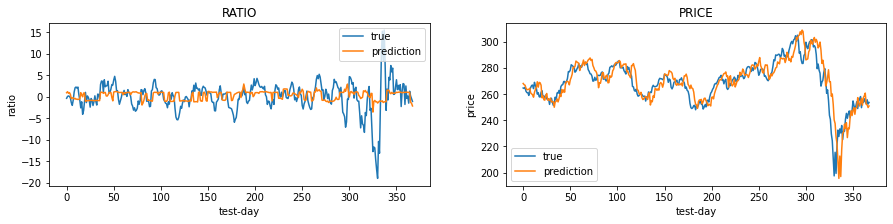

In [24]:
result.evaluation()
result.table()
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)

In [25]:
"""
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
"""

'\ncurrent_train_start = df.loc[prepro.date_to_index(df, train_start), \'date\']\ncurrent_train_end = df.loc[prepro.date_to_index(df, train_end), \'date\']\ncurrent_test_start = df.loc[prepro.date_to_index(df, test_start), \'date\']\ncurrent_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, \'date\']\n\n\n#  각 transfer 구간의 예측값들을 합치기 위하여\ntest_prediction1 = []\ntest_prediction2 = []\ntest_target = []\n\n# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)\nearly_stopping = learn.EarlyStopping(patience=2, verbose=1)\n\n\ngc.collect()\n\ntrain_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, \n                                                       current_train_start, current_train_end,\n                                                       current_test_start, current_test_end,\n                                                       future_day, n_timestep, time_interval)\n\n# input_size, columns reset\ninput_size 